In [4]:
import sys
sys.path.insert(0,"../")

In [5]:
import argparse

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger, MLFlowLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os
import torch

import matplotlib.pyplot as plt

import numpy as np

import wandb
api = wandb.Api()

from causalode import models, data_utils, cv_data_utils, covid_data_utils
from azureml.core.run import Run
from causalode.utils import str2bool

import scipy

run_names = ["2c2xxon3"]

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

def update_dict(main_dict, new_dict):
    for key in new_dict.keys():
        main_dict[key].append(new_dict[key])


# Experiment 

In [6]:
import wandb
api = wandb.Api()

sweep = api.sweep("edebrouwer/causalode/j5joxfxl") # Pendulum Neural ODE

run_names = [run.id for run in sweep.runs if (run.config["gamma"]==8) and (run.config["cf_var_regul"]==0)]
run_names = [run.id for run in sweep.runs]

In [10]:
repeats = 10
t_lim_trimming_start = 0
t_lim_trimming_end = 5
last_model = True

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}



Y_ = []
Y_cf_= []
p_= []
T_= []
X_= []

Y_hat_mean= []
Y_hat_std= []

Y_hat_up= []
Y_hat_down= []
Y_hat_diff= []

Y_hat_cf_mean= []
Y_hat_cf_std= []

Y_hat_cf_up= []
Y_hat_cf_down= []
Y_hat_cf_diff= []


for run_name in run_names:

    print(run_name)
    PATH = "./wandb/"
    paths = [p for p in os.listdir(PATH) if run_name in p]
    assert(len(paths)==1)
    PATH += paths[0] + "/files/causalode/"+run_name+"/checkpoints/"
    
    if last_model:
        PATH += "last.ckpt"
    else:
        PATH+= [f for f in os.listdir(PATH) if "last" not in f][0]
    model_cls = models.VariationalSDE
    model = model_cls.load_from_checkpoint(PATH)

    hparams = dict(model.hparams)

    if hparams["dataset_name"]=="cv":
        dataset_cls = cv_data_utils.CVDataModule
    elif hparams["dataset_name"]=="covid":
        dataset_cls = covid_data_utils.CovidDataModule
    else:
        dataset_cls = data_utils.PendulumDataModule
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()
    print(f"Loaded model and data from {PATH}")

    model.eval()

    Y_hat_samples_list = []
    Y_alea_std_list = []
    Y_hat_cf_samples_list = []
    Y_alea_std_cf_list = []
    Y_list = []
    Y_cf_list = []
    p_list = []
    T_list = []
    X_list = []

    with torch.no_grad():
        for i,batch in enumerate(dataset.test_dataloader()):
            X,Y, T, Y_cf, p, thetas_0 = batch
            Y_list.append(Y)
            Y_cf_list.append(Y_cf)
            p_list.append(p)
            T_list.append(T)
            X_list.append(X)
            times = torch.arange(11).float()
            #times = torch.arange(11).float()


            Y_hat_list = []
            Y_hat_cf_list = []
            Y_alea_std = []
            Y_alea_cf_std = []
            for _ in range(repeats):
                Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat, Y_std = torch.chunk(Y_hat,2,-1)
                else:
                    #Y_std = model.output_scale.repeat(Y_hat.shape)
                    Y_std = torch.zeros_like(Y_hat)

                Y_hat_list.append(Y_hat)
                Y_alea_std.append(torch.sqrt(torch.sigmoid(Y_std)))

                T_cf = (~T.bool()).float()
                Y_hat_cf, reg, logqp = model(X,T_cf,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat_cf, Y_std_cf = torch.chunk(Y_hat_cf,2,-1)
                else:
                    #Y_std_cf = model.output_scale.repeat(Y_hat_cf.shape)
                    Y_std_cf = torch.zeros_like(Y_hat_cf)
                    
                Y_hat_cf_list.append(Y_hat_cf)
                Y_alea_cf_std.append(torch.sqrt(torch.sigmoid(Y_std_cf)))

            Y_hat_samples = torch.cat(Y_hat_list,0)
            Y_alea_std = torch.cat(Y_alea_std,0)
            Y_hat_cf_samples = torch.cat(Y_hat_cf_list,0)
            Y_alea_std_cf = torch.cat(Y_alea_cf_std,0)

            Y_hat_samples_list.append(Y_hat_samples)
            Y_alea_std_list.append(Y_alea_std)
            Y_hat_cf_samples_list.append(Y_hat_cf_samples)
            Y_alea_std_cf_list.append(Y_alea_std_cf)

    Y_hat_samples = torch.cat(Y_hat_samples_list,1)
    Y_alea_std = torch.cat(Y_alea_std_list,1)
    Y_hat_cf_samples = torch.cat(Y_hat_cf_samples_list,1)
    Y_alea_std_cf = torch.cat(Y_alea_std_cf_list,1)

    Y_.append(torch.cat(Y_list,0))
    Y_cf_.append(torch.cat(Y_cf_list,0))
    p_.append(torch.cat(p_list,0))
    T_.append(torch.cat(T_list,0))
    X_.append(torch.cat(X_list,0))

    Y_hat_mean.append(Y_hat_samples.mean(0))
    Y_hat_std.append(Y_hat_samples.std(0))

    Y_hat_up.append((Y_hat_samples+1.96*Y_alea_std).max(0)[0])
    Y_hat_down.append((Y_hat_samples-1.96*Y_alea_std).min(0)[0])
    Y_hat_diff.append(Y_hat_up[-1] - Y_hat_down[-1])
    
    Y_hat_cf_mean.append(Y_hat_cf_samples.mean(0))
    Y_hat_cf_std.append(Y_hat_cf_samples.std(0))

    Y_hat_cf_up.append((Y_hat_cf_samples+1.96*Y_alea_std_cf).max(0)[0])
    Y_hat_cf_down.append((Y_hat_cf_samples-1.96*Y_alea_std_cf).min(0)[0])
    Y_hat_cf_diff.append(Y_hat_cf_up[-1] - Y_hat_cf_down[-1])

    times_plot = times[1:]    

288ywy2d
Loaded model and data from ./wandb/run-20210722_122011-288ywy2d/files/causalode/288ywy2d/checkpoints/last.ckpt
lnh6zwxs
Loaded model and data from ./wandb/run-20210722_114951-lnh6zwxs/files/causalode/lnh6zwxs/checkpoints/last.ckpt
v4jizqyv
Loaded model and data from ./wandb/run-20210722_112024-v4jizqyv/files/causalode/v4jizqyv/checkpoints/last.ckpt


In [217]:
#50%
strategy_type = "uncertainty"

print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

Strategy type : uncertainty
Factual : 0.02384885400533676+- 0.004665891174226999
CFactual : 0.03642270341515541+- 0.006424448918551207
PEHE : 0.04706985875964165+- 0.004763129632920027


/home/edward/anaconda3/envs/causalode/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
#Full
print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

Strategy type : uncertainty
Factual : 0.038676027208566666+- 0.008289183489978313
CFactual : 0.06997188180685043+- 0.00875450111925602
PEHE : 0.08550620079040527+- 0.008112273178994656


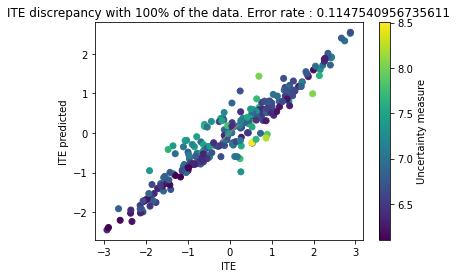

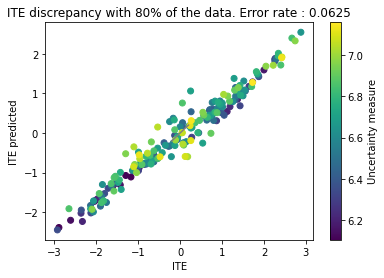

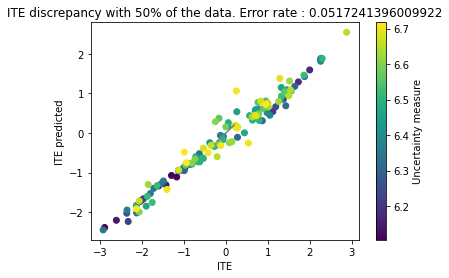

In [77]:
#ite_mse = ((Y-Y_cf)-(Y_hat_mean-Y_hat_cf_mean))[:,:5].pow(2).mean(1)
idx = 2

t_eval = 5
cost = 0.1
ite = ((T_[idx][:,None]*2-1)*(Y_[idx]-Y_cf_[idx])[:,t_eval]).mean(1)
ite_hat = ((T_[idx][:,None]*2-1)*(Y_hat_mean[idx]-Y_hat_cf_mean[idx])[:,t_eval]).mean(1)
ite_std = Y_hat_std[idx][:,t_eval] 

mask = torch.sort((Y_hat_diff[idx]+Y_hat_cf_diff[idx])[:,t_eval,0])[1][:int(1*len(Y_hat_diff[idx]))]

plt.figure()
plt.scatter(ite,ite_hat, c = (Y_hat_diff[idx]+Y_hat_cf_diff[idx])[:,t_eval])
plt.plot(np.linspace(-0.2,0.2),np.linspace(-0.2,0.2), color = "grey")
plt.xlabel("ITE")
plt.ylabel("ITE predicted")
#plt.ylim(0,8)
bad_proportion = ((ite[mask]<0) & (ite_hat[mask]>0)).sum()/(ite_hat[mask]>0).sum()
plt.title(f"ITE discrepancy with 100% of the data. Error rate : {bad_proportion}")
plt.colorbar(label = "Uncertainty measure")
plt.show()

mask = torch.sort((Y_hat_diff[idx]+Y_hat_cf_diff[idx])[:,t_eval,0])[1][:int(0.8*len(Y_hat_diff[idx]))]

plt.figure()
plt.scatter(ite[mask],ite_hat[mask], c = (Y_hat_diff[idx]+Y_hat_cf_diff[idx])[mask,t_eval])
plt.plot(np.linspace(-0.2,0.2),np.linspace(-0.2,0.2), color = "grey")
plt.xlabel("ITE")
plt.ylabel("ITE predicted")
#plt.ylim(0,8)
bad_proportion = ((ite[mask]<0) & (ite_hat[mask]>0)).sum()/(ite_hat[mask]>0).sum()
plt.title(f"ITE discrepancy with 80% of the data. Error rate : {bad_proportion}")
plt.colorbar(label = "Uncertainty measure")
plt.show()


mask = torch.sort((Y_hat_diff[idx]+Y_hat_cf_diff[idx])[:,t_eval,0])[1][:int(0.5*len(Y_hat_diff[idx]))]

plt.figure()
plt.scatter(ite[mask],ite_hat[mask], c = (Y_hat_diff[idx]+Y_hat_cf_diff[idx])[mask,t_eval])
plt.plot(np.linspace(-0.2,0.2),np.linspace(-0.2,0.2), color = "grey")
plt.xlabel("ITE")
plt.ylabel("ITE predicted")
#plt.ylim(0,8)
bad_proportion = ((ite[mask]<0) & (ite_hat[mask]>0)).sum()/(ite_hat[mask]>0).sum()
plt.title(f"ITE discrepancy with 50% of the data. Error rate : {bad_proportion}")
plt.colorbar(label = "Uncertainty measure")
plt.show()


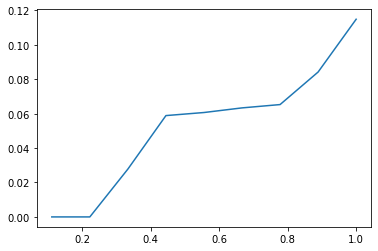

In [78]:
#ite_mse = ((Y-Y_cf)-(Y_hat_mean-Y_hat_cf_mean))[:,:5].pow(2).mean(1)
t_eval = 5
ite = ((T_[idx][:,None]*2-1)*(Y_[idx]-Y_cf_[idx])[:,t_eval]).mean(1)
ite_hat = ((T_[idx][:,None]*2-1)*(Y_hat_mean[idx]-Y_hat_cf_mean[idx])[:,t_eval]).mean(1)

error_rates = []
props = np.linspace(0,1,10)
for prop in props:

    mask = torch.sort((Y_hat_diff[idx]+Y_hat_cf_diff[idx])[:,t_eval,0])[1][:int(prop*len(Y_hat_diff[idx]))]
    error_rate = ((ite[mask]<0) & (ite_hat[mask]>0)).sum()/(ite_hat[mask]>0).sum()
    error_rates.append(error_rate)

plt.plot(props,error_rates)

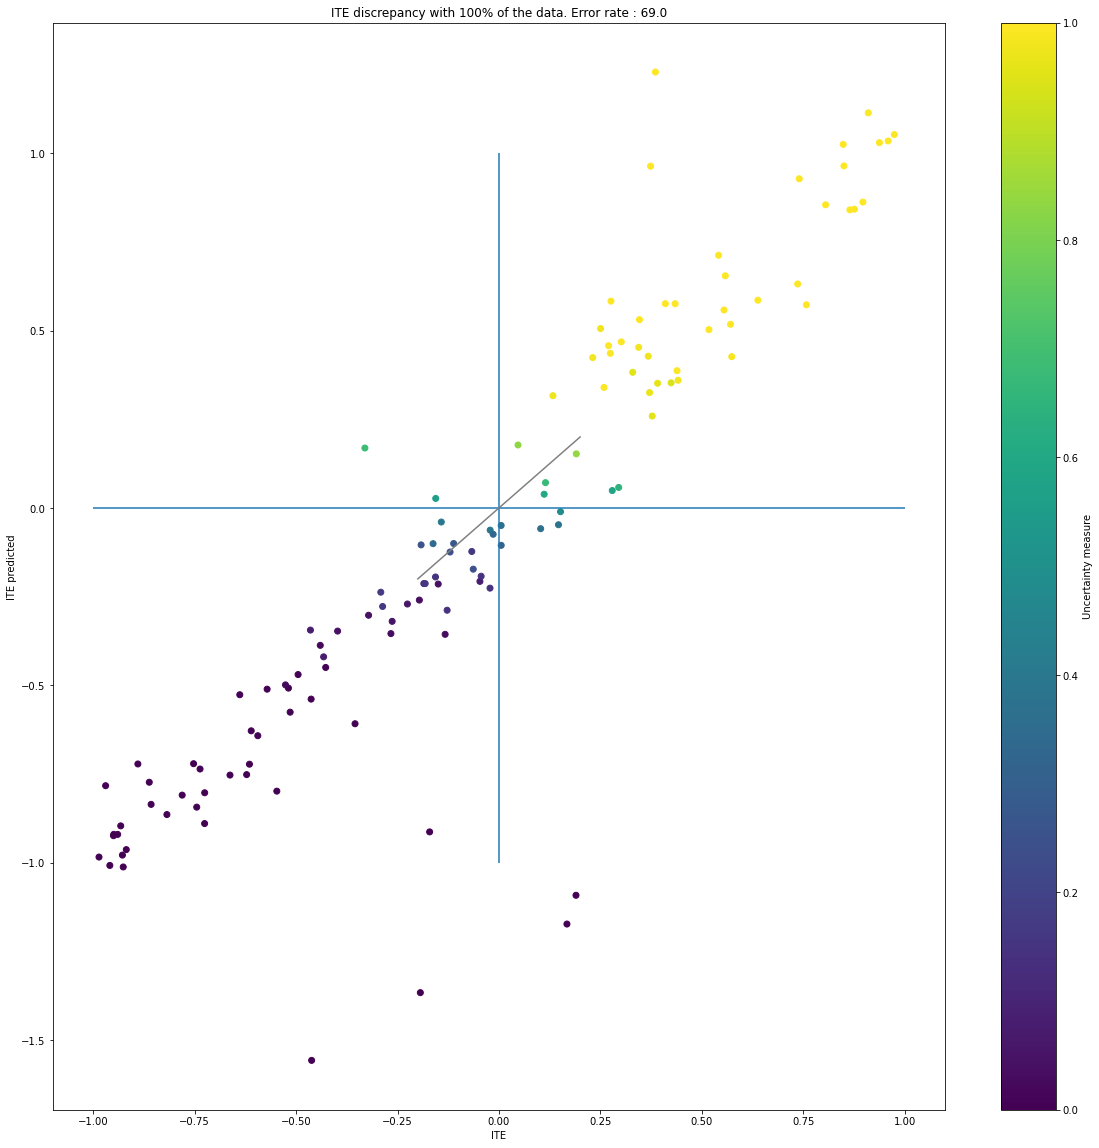

In [17]:
#ite_mse = ((Y-Y_cf)-(Y_hat_mean-Y_hat_cf_mean))[:,:5].pow(2).mean(1)
from scipy.stats import norm
t_eval = 3
cost = 0.1
ite = ((T_[idx][:,None]*2-1)*(Y_[idx]-Y_cf_[idx])[:,t_eval]).mean(1)
ite_hat = ((T_[idx][:,None]*2-1)*(Y_hat_mean[idx]-Y_hat_cf_mean[idx])[:,t_eval])
ite_std = (Y_hat_std[idx]+Y_hat_cf_std[idx])[:,t_eval]

prob_over_0 = 1-norm.cdf(-ite_hat/ite_std)

mask = (ite>-1) * (ite<1)

plt.figure(figsize=(20,20))
plt.scatter(ite[mask],ite_hat[mask], c = prob_over_0[mask])
plt.plot(np.linspace(-0.2,0.2),np.linspace(-0.2,0.2), color = "grey")
plt.xlabel("ITE")
plt.ylabel("ITE predicted")
plt.hlines(0,-1,1)
plt.vlines(0,-1,1)

#plt.ylim(0,8)
bad_proportion = ((ite[mask]<0) & (ite_hat[mask]>0)).sum()/(ite_hat[mask]>0).sum()
plt.title(f"ITE discrepancy with 100% of the data. Error rate : {bad_proportion}")
plt.colorbar(label = "Uncertainty measure")
plt.show()

In [18]:
mask = (ite>-1) * (ite<1)

In [19]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(ite[mask]>0, ite_hat[mask])
precision_, recall_, thresholds = precision_recall_curve(ite[mask]>0, prob_over_0[mask])

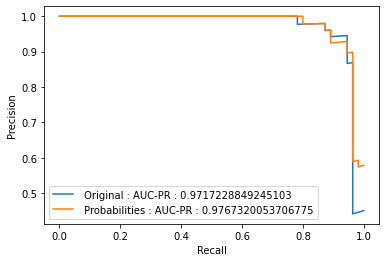

In [20]:
plt.plot(recall,precision, label = f" Original : AUC-PR : {auc(recall,precision)}")
plt.plot(recall_,precision_,label = f" Probabilities : AUC-PR : {auc(recall_,precision_)}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

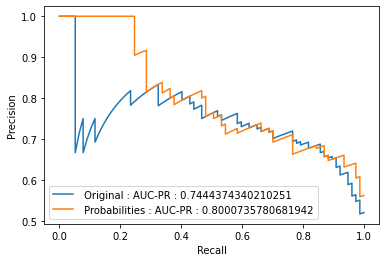

tensor(72.)
tensor(72.)


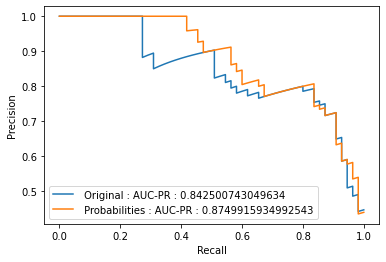

tensor(71.)
tensor(71.)


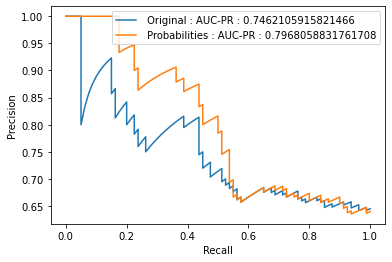

tensor(58.)
tensor(58.)


In [41]:
from sklearn.metrics import precision_recall_curve, auc

precisions = []
precisions_ = []
AUC_PR = []
AUC_PR_ = []

for idx in range(3):
    t_eval = 6
    cost = 0.1
    ite = ((T_[idx][:,None]*2-1)*(Y_[idx]-Y_cf_[idx])[:,t_eval]).mean(1)
    ite_hat = ((T_[idx][:,None]*2-1)*(Y_hat_mean[idx]-Y_hat_cf_mean[idx])[:,t_eval])
    ite_std = (Y_hat_std[idx]+Y_hat_cf_std[idx])[:,t_eval]
    prob_over_0 = 1-norm.cdf(-ite_hat/ite_std)

    mask = (ite>-1) * (ite<1)


    precision, recall, thresholds = precision_recall_curve(ite[mask]>0, ite_hat[mask])
    precision_, recall_, thresholds = precision_recall_curve(ite[mask]>0, prob_over_0[mask])
    
    precision_interp = np.interp(np.linspace(0,1),np.flip(recall),np.flip(precision))
    precision_interp_ = np.interp(np.linspace(0,1),np.flip(recall_),np.flip(precision_))
    
    precisions.append(precision_interp)
    precisions_.append(precision_interp_)
    
    AUC_PR.append(auc(recall,precision))
    AUC_PR_.append(auc(recall_,precision_))

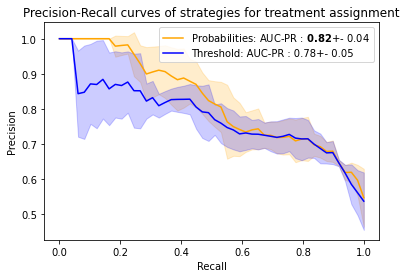

In [76]:
precisions = np.stack(precisions)
precisions_ = np.stack(precisions_)

auc_pr = np.array(AUC_PR)
auc_pr_ = np.array(AUC_PR_)

plt.figure()

colors = {"Threshold" : "blue", "Probabilities" : "orange"}

for i, (p, pr, name) in enumerate(zip([precisions_,precisions],[auc_pr_,auc_pr], ["Probabilities","Threshold"])):
    mu = p.mean(0)
    std = p.std(0)
    pr_m = pr.mean()
    pr_std = pr.std()
    plt.fill_between(np.linspace(0,1),mu-std,mu+std, alpha = 0.2, color = colors[name])
    if name=="Probabilities":
        plt.plot(np.linspace(0,1),mu, label = name + ": AUC-PR : "+r"$\bf{" + str(np.round(pr_m,2)) + "}$" + f"+- {pr_std:.2f}", color = colors[name])
    else:
        plt.plot(np.linspace(0,1),mu, label = name + ": AUC-PR : " + str(np.round(pr_m,2))  + f"+- {pr_std:.2f}", color = colors[name])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves of strategies for treatment assignment")
plt.legend()
plt.savefig("./plots/pr_strategy.pdf")
plt.show()

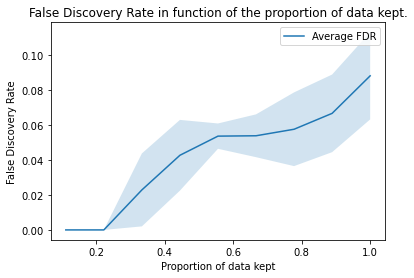

In [91]:
t_eval = 5

error_rates_list = []

for idx in range(3):

    ite = ((T_[idx][:,None]*2-1)*(Y_[idx]-Y_cf_[idx])[:,t_eval]).mean(1)
    ite_hat = ((T_[idx][:,None]*2-1)*(Y_hat_mean[idx]-Y_hat_cf_mean[idx])[:,t_eval])[:,0]

    error_rates = []
    props = np.linspace(0,1,10)
    for prop in props:

        mask = torch.sort((Y_hat_diff[idx]+Y_hat_cf_diff[idx])[:,t_eval,0])[1][:int(prop*len(Y_hat_diff[idx]))]
        error_rate = ((ite[mask]<0) & (ite_hat[mask]>0)).sum()/(ite_hat[mask]>0).sum()
        error_rates.append(error_rate)

    error_rates_list.append(torch.Tensor(error_rates))
error_rates = torch.stack(error_rates_list)
er_mu = error_rates.mean(0)
er_std = error_rates.std(0)

plt.fill_between(props,er_mu-er_std,er_mu+er_std,alpha = 0.2)
plt.plot(props,er_mu, label  = "Average FDR")
plt.xlabel("Proportion of data kept")
plt.ylabel("False Discovery Rate")
plt.title("False Discovery Rate in function of the proportion of data kept.")
plt.legend()
plt.savefig("./plots/FDR_percent.pdf")
plt.show()